In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [65]:
separable_df = pd.read_csv("linearly-separable-data.csv")
non_separable_df = pd.read_csv("non-separable-data.csv")
non_linearly_separable_df = pd.read_excel("non-linearly-separable-data.xlsx")

In [66]:
separable_df = separable_df[separable_df["color"] <= 1]
#separable_df.to_csv("sep.csv", index = False)
non_separable_df = non_separable_df[(non_separable_df["color"] == 0) | (non_separable_df["color"] == 2)]
#non_separable_df.to_csv("sep2.csv", index = False)

<AxesSubplot:xlabel='x', ylabel='y'>

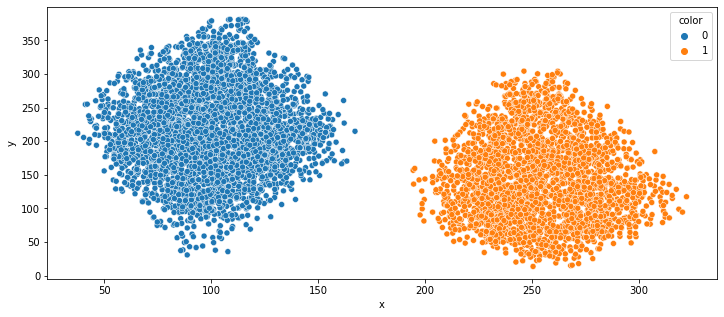

In [67]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x = "x", y = "y", hue = "color", data = separable_df)

<AxesSubplot:xlabel='x', ylabel='y'>

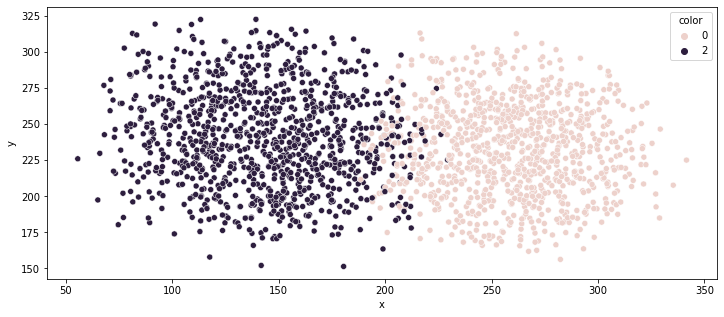

In [68]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x = "x", y = "y", hue = "color", data = non_separable_df)

<AxesSubplot:xlabel='x', ylabel='y'>

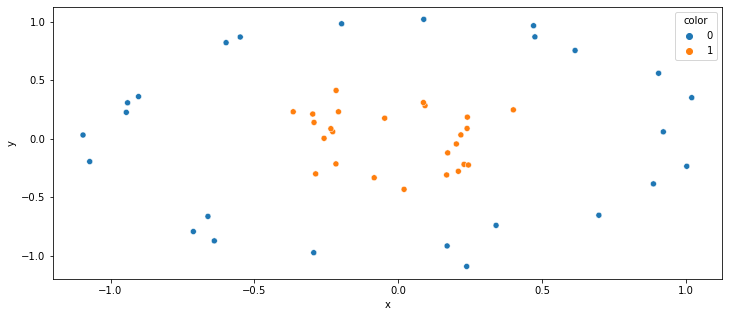

In [69]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x = "x", y = "y", hue = "color", data = non_linearly_separable_df)